📌 Colab Cell 1 — Install libraries

In [ ]:
!pip install torch torchvision timm transformers matplotlib scipy


📌 Colab Cell 2 — Import libraries

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import matplotlib.pyplot as plt
import numpy as np


📌 Colab Cell 3 — Load Oxford Flowers Dataset (simple)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_ds = datasets.Flowers102(root="./data", split='train', download=True, transform=transform)
test_ds  = datasets.Flowers102(root="./data", split='test', download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=16)


100%|██████████| 345M/345M [00:16<00:00, 21.3MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.18MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 8.03MB/s]


📌 Colab Cell 4 — Simple Prompt Module

This adds a few trainable tokens to ViT.

In [ ]:
class PromptTuning(nn.Module):
    def __init__(self, prompt_len=5, embed_dim=768):
        super().__init__()
        self.prompt = nn.Parameter(torch.randn(prompt_len, embed_dim))

    def forward(self, x):
        B = x.size(0)
        prompt = self.prompt.unsqueeze(0).expand(B, -1, -1)
        return torch.cat([prompt, x], dim=1)


📌 Colab Cell 5 — Build Prompt-Tuned ViT

We freeze the ViT weights.

In [ ]:
class PromptViT(nn.Module):
    def __init__(self, num_classes=102, prompt_len=5):
        super().__init__()

        # Load pretrained ViT
        self.vit = timm.create_model("vit_base_patch16_224", pretrained=True)

        embed_dim = self.vit.embed_dim

        # Freeze all ViT parameters
        for p in self.vit.parameters():
            p.requires_grad = False

        # Add prompt tokens
        self.prompt = PromptTuning(prompt_len=prompt_len, embed_dim=embed_dim)

        # Replace classification head (trainable)
        self.vit.head = nn.Linear(embed_dim, num_classes)

        for p in self.vit.head.parameters():
            p.requires_grad = True

    def forward(self, x):
        B = x.size(0)

        # Step 1: Patch embedding (built-in)
        x = self.vit.patch_embed(x)       # [B, D, H', W']
        x = self.vit._pos_embed(x)        # Adds class token + position embedding
                                          # Now x = [B, 1 + N, 768]

        # Remove class token temporarily
        cls_token, x = x[:, :1, :], x[:, 1:, :]

        # Step 2: Insert prompts
        x = self.prompt(x)               # [B, P + N, 768]

        # Step 3: Reattach class token
        x = torch.cat([cls_token, x], dim=1)

        # Step 4: Run transformer blocks
        x = self.vit.blocks(x)
        x = self.vit.norm(x)

        # Step 5: Classifier head on CLS token
        return self.vit.head(x[:, 0])

    def get_attentions(self, x):
      global attns
      attns = []
      logits = self.forward(x)
      return logits, attns




📌 Colab Cell 6 — Train loop

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = PromptViT().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {"params": model.prompt.parameters()},
    {"params": model.vit.head.parameters()}
], lr=1e-3)


📌 Modify Model to Return Attentions

In [ ]:
attns = []

def patched_attn_forward(self, x, **kwargs):
    B, N, C = x.shape

    qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
    qkv = qkv.permute(2, 0, 3, 1, 4)
    q, k, v = qkv[0], qkv[1], qkv[2]

    attn = (q @ k.transpose(-2, -1)) * self.scale
    attn = attn.softmax(dim=-1)

    # SAVE attention
    attns.append(attn.detach())

    attn = self.attn_drop(attn)
    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = self.proj(x)
    x = self.proj_drop(x)
    return x


In [ ]:
for blk in model.vit.blocks:
    blk.attn.forward = patched_attn_forward.__get__(blk.attn, type(blk.attn))


In [ ]:
from tqdm import tqdm
import torch

epochs = 3
best_acc = 0.0

for epoch in range(epochs):
    model.train()
    total, correct = 0, 0
    running_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item()
        total += labels.size(0)
        correct += (preds.argmax(1) == labels).sum().item()

        acc = correct / total * 100
        pbar.set_postfix({"loss": f"{running_loss/total:.4f}", "acc": f"{acc:.2f}%"})

    # Epoch summary
    epoch_acc = correct / total * 100
    print(f"Epoch {epoch+1}: Train Acc = {epoch_acc:.2f}%")

    # Save checkpoint for this epoch
    torch.save({
        "epoch": epoch + 1,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "accuracy": epoch_acc,
    }, f"checkpoint_epoch_{epoch+1}.pth")

    # Save best model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model updated & saved!")


Epoch 1/3: 100%|██████████| 64/64 [24:38<00:00, 23.10s/it, loss=0.1229, acc=67.84%]


Epoch 1: Train Acc = 67.84%
🔥 Best model updated & saved!


Epoch 2/3: 100%|██████████| 64/64 [24:38<00:00, 23.10s/it, loss=0.0073, acc=99.80%]


Epoch 2: Train Acc = 99.80%
🔥 Best model updated & saved!


Epoch 3/3: 100%|██████████| 64/64 [24:33<00:00, 23.03s/it, loss=0.0027, acc=100.00%]


Epoch 3: Train Acc = 100.00%
🔥 Best model updated & saved!


📌 Colab Cell 7 — Evaluate accuracy

In [ ]:
model.eval()
total, correct = 0, 0

pbar = tqdm(test_loader, desc="Evaluating")

with torch.no_grad():
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        preds = model(images)

        total += labels.size(0)
        correct += (preds.argmax(1) == labels).sum().item()

        acc = correct / total * 100
        pbar.set_postfix({"acc": f"{acc:.2f}%"})

final_acc = correct / total * 100
print(f"\n Test Accuracy: {final_acc:.2f}%")



Evaluating: 100%|██████████| 385/385 [1:09:22<00:00, 10.81s/it, acc=98.70%]


 Test Accuracy: 98.70%


📌 Colab Cell 8 — Attention Rollout Function

In [ ]:
import torch.nn.functional as F

def attention_rollout(attentions):
    # attentions: list of attention maps from each transformer block
    result = torch.eye(attentions[0].size(-1)).to(attentions[0].device)

    for attn in attentions:
        attn_heads_fused = attn.mean(dim=1)      # average over heads
        attn_heads_fused += torch.eye(attn_heads_fused.size(-1)).to(attn.device)
        attn_heads_fused = attn_heads_fused / attn_heads_fused.sum(dim=-1, keepdim=True)
        result = torch.matmul(attn_heads_fused, result)

    return result


📌 Colab Cell 9 — Visualize Rollout Heatmap for Any Image

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def visualize_rollout(img_path):
    model.eval()
    img = Image.open(img_path).convert("RGB")

    transform_vis = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    inp = transform_vis(img).unsqueeze(0).to(device)

    logits, attns = model.get_attentions(inp)

    # attns: list of [1, heads, tokens, tokens]
    num_prompts = model.prompt.prompt.shape[0]  # e.g. 5

    # CLS token attends to everything
    rollout = torch.stack([a.mean(1) for a in attns]).mean(0)[0]  # [tokens, tokens]
    rollout = rollout[0, 1 + num_prompts:]  # take CLS row, remove prompt tokens
    size = int(rollout.shape[0] ** 0.5)
    rollout = rollout.reshape(size, size).cpu().numpy()


    rollout = (rollout - rollout.min()) / (rollout.max() - rollout.min())


    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Input")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(rollout, cmap="jet")
    plt.title("Attention Rollout")
    plt.axis("off")

    plt.show()


In [ ]:
import torchvision.utils as vutils

img, label = test_ds[0]
vutils.save_image(img, "example_flower.jpg")


Usage:

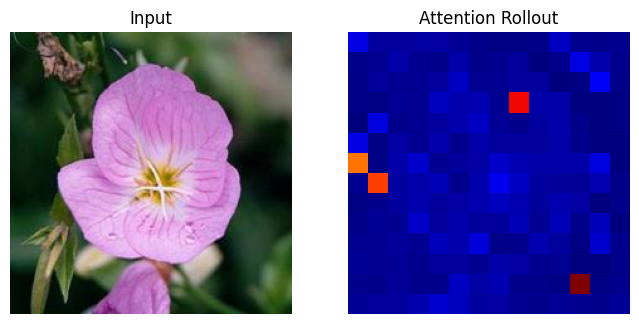

In [ ]:
visualize_rollout("example_flower.jpg")


📌 Colab Cell 10 — Visualize Model Prediction + Heatmap

In [ ]:
def predict_and_explain(img_path):
    model.eval()
    img = Image.open(img_path).convert("RGB")

    transform_vis = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    inp = transform_vis(img).unsqueeze(0).to(device)

    # Prediction
    with torch.no_grad():
        preds = model(inp)
        pred_class = preds.argmax(1).item()

    print("Predicted Class:", pred_class)

    # Heatmap
    visualize_rollout(img_path)


Usage:

Predicted Class: 36


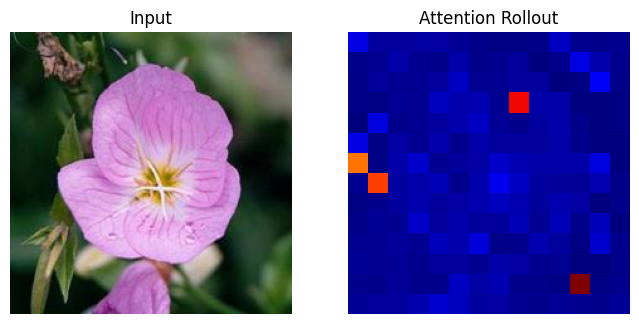

In [ ]:
predict_and_explain("example_flower.jpg")
